# <center> *mocalum* tutorial 2 <br><br> Working with multi-lidars<center>

A notebook by Nikola Vasiljević
    
 ## Introduction
 This is an interactive tutorial that will introduce you how to setup `mocalum` to work with multi-lidar configurations (i.e., dual- and triple- Doppler setups). We will follow the same workflow as one explained in  `tutorial 1`. Consult `tutorial 1` for a detailed description of the workflow and `mocalum`.
    

In [1]:
import numpy as np           
import matplotlib.pyplot as plt
import xarray as xr

import mocalum as mc

from mocalum_tutorial import plot_md_scan_setup

## Create and explore mocalum object

We start our tutorial by creating an instance of `mocalum` object:

In [2]:
mc_dual_Doppler = mc.Mocalum()

## Adding lidars and configuring uncertanty

Lets consider a dual-Doppler setup with two lidars, named `koshava` and `sterenn`, located at positions of (0,500,0) and (0,-500,0) respectevely with the same standard uncertainties:
- estimation uncertainty of radial velocity of 0.1 m/s 
- ranging uncertainty of 5 m
- azimuth uncertainty of 0.1 deg
- elevation uncertainty of 0.1 deg
We will consider that uncertainty values are not correlated between two lidars.

To add these two lidars we simply execute `add_lidar` method twice in row:

In [3]:
koshava_xyz = np.array([500,500,0])
sterenn_xyz = np.array([500,-500,0])


unc_cfg = {'unc_az'   : 0.1,
           'unc_el'   : 0.1,
           'unc_rng'  : 5,
           'unc_est'  : 0.1,
           'corr_coef':0}

mc_dual_Doppler.add_lidar('koshava', koshava_xyz, unc_cfg)
mc_dual_Doppler.add_lidar('sterenn', sterenn_xyz, unc_cfg)

The lidar information are added to the measurement configuration dictionary stored inside `data` subobject:

In [4]:
mc_dual_Doppler.data.meas_cfg['koshava']

{'position': array([500, 500,   0]),
 'uncertainty': {'unc_az': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_el': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_rng': {'mu': 0, 'std': 5, 'units': 'm'},
  'unc_est': {'mu': 0, 'std': 0.1, 'units': 'm.s^-1'},
  'corr_coef': 0},
 'config': {}}

In [5]:
mc_dual_Doppler.data.meas_cfg['sterenn']

{'position': array([ 500, -500,    0]),
 'uncertainty': {'unc_az': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_el': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_rng': {'mu': 0, 'std': 5, 'units': 'm'},
  'unc_est': {'mu': 0, 'std': 0.1, 'units': 'm.s^-1'},
  'corr_coef': 0},
 'config': {}}

## Setting up measurement scenario for previously added lidar

Following the lidar placement and uncertainty configuration we will configure the measurement scenario which the two lidars will 'virtually' perform. In this example that will be an arbitrary trajectory containing a number of measurement points on a horizontal line located at 100 m above ground level. To add this trajectory we will use the built-in method `generate_complex_trajectory`, which requires following inputs:
 - lidar ids provided as a list of strings for which the complex trajectory will be generated
 - Scan configuration as a dictionary containing following required parameter:
    - `points` : numpy array of measurement points provided as triplets of coordinates (x, y, z)
    - `no_scans` : number of scans through the points
    - `acq_time` : acquisition time of LOS measurements   
    
   while following parameters are optional: 
    - `max_speed` : max permitted angular speed
    - `max_acc` : max permitted angular acceleration
    - `sync` : indicates whether to synchronize ('sync':True) or not ('sync':False) motion among multiple lidars
    

> **mocalum note**: If `max_speed` or `max_acc` are not provided, `mocalum` considers that there are no kinematic restrictions, thus values for these parameters are consider to be infinit. This practically means that in case of a CT scan scan the time it takes to move between CT scan points is 0 s, and only acqusition time will be the mechanism which will the time spent to peform measurement scenario. 

In [52]:
pts_x = np.arange(0, 1000, 100)

pts = np.array([pts_x, np.full(len(pts_x), 0), np.full(len(pts_x), 100)]).T

CT_cfg = {
    'points': pts,
    'no_scans' : 21000,
    'acq_time' :1,
    'sync':True,
}

mc_dual_Doppler.generate_complex_trajectory(['koshava', 'sterenn'],CT_cfg)

Now if inspeact measurement configuration dictionary for `koshava` and `sterenn` we will notice that they became updated with CT (**c**omplex **t**rajectory) scan configuration:

In [53]:
mc_dual_Doppler.data.meas_cfg['koshava']

{'position': array([500, 500,   0]),
 'uncertainty': {'unc_az': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_el': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_rng': {'mu': 0, 'std': 5, 'units': 'm'},
  'unc_est': {'mu': 0, 'std': 0.1, 'units': 'm.s^-1'},
  'corr_coef': 0},
 'config': {'scan_type': 'CT',
  'max_scn_speed': 50,
  'max_scn_acc': 100,
  'scn_speed': 0,
  'no_los': 10,
  'no_scans': 21000,
  'sectrsz': 83.65980825409008,
  'scn_tm': 10.0,
  'rtn_tm': 0.0,
  'az': array([225.        , 218.65980825, 210.96375653, 201.80140949,
         191.30993247, 180.        , 168.69006753, 158.19859051,
         149.03624347, 141.34019175]),
  'el': array([ 8.04946698,  8.87639508,  9.73147547, 10.51973489, 11.09580328,
         11.30993247, 11.09580328, 10.51973489,  9.73147547,  8.87639508]),
  'rng': array([714.14284285, 648.07406984, 591.60797831, 547.72255751,
         519.61524227, 509.90195136, 519.61524227, 547.72255751,
         591.60797831, 648.07406984])}}

In [54]:
mc_dual_Doppler.data.meas_cfg['sterenn']

{'position': array([ 500, -500,    0]),
 'uncertainty': {'unc_az': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_el': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_rng': {'mu': 0, 'std': 5, 'units': 'm'},
  'unc_est': {'mu': 0, 'std': 0.1, 'units': 'm.s^-1'},
  'corr_coef': 0},
 'config': {'scan_type': 'CT',
  'max_scn_speed': 50,
  'max_scn_acc': 100,
  'scn_speed': 0,
  'no_los': 10,
  'no_scans': 21000,
  'sectrsz': 83.65980825409008,
  'scn_tm': 10.0,
  'rtn_tm': 0.0,
  'az': array([315.        , 321.34019175, 329.03624347, 338.19859051,
         348.69006753,   0.        ,  11.30993247,  21.80140949,
          30.96375653,  38.65980825]),
  'el': array([ 8.04946698,  8.87639508,  9.73147547, 10.51973489, 11.09580328,
         11.30993247, 11.09580328, 10.51973489,  9.73147547,  8.87639508]),
  'rng': array([714.14284285, 648.07406984, 591.60797831, 547.72255751,
         519.61524227, 509.90195136, 519.61524227, 547.72255751,
         591.60797831, 648.07406984])}}

Besides the update of the measurement configuration dictionary, two probing `xarray` datasets were created, each corresponding to one of the two lidars:

In [55]:
mc_dual_Doppler.data.probing['koshava']

<xarray.Dataset>
Dimensions:      (time: 210000)
Coordinates:
  * time         (time) float64 1.0 2.0 3.0 4.0 ... 2.1e+05 2.1e+05 2.1e+05
Data variables:
    az           (time) float64 225.0 218.7 211.0 201.8 ... 158.2 149.0 141.3
    el           (time) float64 8.049 8.876 9.731 10.52 ... 10.52 9.731 8.876
    rng          (time) float64 714.1 648.1 591.6 547.7 ... 547.7 591.6 648.1
    x            (time) float64 0.0 100.0 200.0 300.0 ... 700.0 800.0 900.0
    y            (time) float64 -5.684e-14 -1.137e-13 ... -1.137e-13 0.0
    z            (time) float64 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0
    unc_az       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_el       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_rng      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_est      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sectrsz      float64 83.66
    no_scans     int64 21000
    no_los       int64 10
    scan_tm      float64 10.0
    return_tm    float64 0.0
    lidar_pos_x  int64 500
    lidar_pos_y  int64 500
    lidar_pos_z  int64 0
Attributes:
    title:    Lidar atmosphere probing dataset

In [56]:
mc_dual_Doppler.data.probing['sterenn']

<xarray.Dataset>
Dimensions:      (time: 210000)
Coordinates:
  * time         (time) float64 1.0 2.0 3.0 4.0 ... 2.1e+05 2.1e+05 2.1e+05
Data variables:
    az           (time) float64 315.0 321.3 329.0 338.2 ... 21.8 30.96 38.66
    el           (time) float64 8.049 8.876 9.731 10.52 ... 10.52 9.731 8.876
    rng          (time) float64 714.1 648.1 591.6 547.7 ... 547.7 591.6 648.1
    x            (time) float64 -1.705e-13 100.0 200.0 ... 700.0 800.0 900.0
    y            (time) float64 0.0 -5.684e-14 -1.137e-13 ... 0.0 -1.705e-13 0.0
    z            (time) float64 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0
    unc_az       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_el       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_rng      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_est      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sectrsz      float64 83.66
    no_scans     int64 21000
    no_los       int64 10
    scan_tm      float64 10.0
    return_tm    float64 0.0
    lidar_pos_x  int64 500
    lidar_pos_y  int64 -500
    lidar_pos_z  int64 0
Attributes:
    title:    Lidar atmosphere probing dataset

For convinience a plotting function `plot_md_scan_setup` has been implemented in `mocalum_tutorial` that helps visually representing the configure measurement scenario:

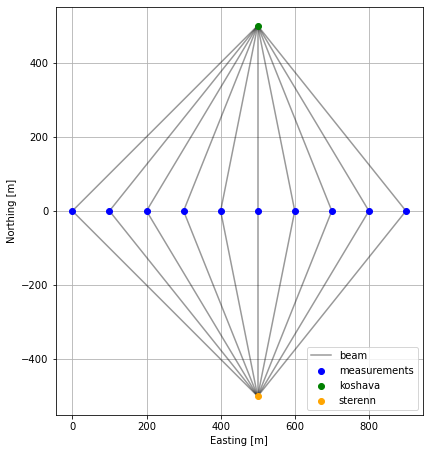

In [57]:
plot_md_scan_setup(['koshava', 'sterenn'], mc_dual_Doppler)

To actually sample uncertainties we need to execture command `generate_uncertainties` for each lidar:

In [58]:
mc_dual_Doppler.generate_uncertainties('koshava')
mc_dual_Doppler.generate_uncertainties('sterenn')

Let's verify that the standard deviation of for example radial wind speed estimation uncertainty is equal/close to what we set earlier, that is 0.1 m/s:

In [59]:
mc_dual_Doppler.data.probing['koshava'].unc_el.std()

<xarray.DataArray 'unc_el' ()>
array(0.1000699)

## Generating flow field entailing measurement points

Based on the measurement scenario `mocalum` calculates necessary dimensions and resolution of flow field box (3D for uniform or 4D for turbulent), generates the flow field data and saves them as `xarray` dataset. In this tutorial we will generate `turbulent` flow field, which done using a wrapper around [pyconturb](https://gitlab.windenergy.dtu.dk/pyconturb/pyconturb) package. The method `generate_flow_field` requires following input parameters:

 - `lidar_id` : string or list of string corresponding to lidar ids
 - `atmo_cfg` : dictionary describing mean flow parameters, containing following keys:
     - `wind_speed` : mean horizontal wind speed in m/s
     - `upward_velocity` : vertical wind speed in m/s
     - `wind_from_direction` : mean wind direction in deg
     - `reference_height` : height at which wind speed is given in m
     - `shear_exponent` : vertical wind shear exponent 
     
 - `flow_type` : flow field type to be generated, it can be `uniform` or `turbulent`

Let's define and generate flow field for 'koshava' and 'sterenn', which will be stored under `data.ffield`.

> **mocalum note**: Unlike data stored for a `uniform` flow field, the turbulent flow field coordinates x and y are rotated such that x coordinate is aligned with wind direction, while y coordinate is perpendicular to the wind direction. This is done to efficiently store data. However, we keep track of orientation by having physical coordinates which are Easting and Northing, which are dependent of x and y. More details about the coordinate systems and flow field generation are explained in `tutorial 3`.

In [60]:
atmo_cfg={'wind_speed':10,
          'upward_velocity':0,
          'wind_from_direction':90,
          'reference_height':100, # we set the reference height same as the scanned height 
          'shear_exponent':0.2}

mc_dual_Doppler.generate_flow_field(['koshava', 'sterenn'], atmo_cfg, 'turbulent')


# Project flow field on line-of-sight(s)

Now we have all elements to calculate what wind lidars would measure, thus to project the flow field on the lidar LOSs. We do this by executing method `project_to_los` for each lidar:

In [61]:
mc_dual_Doppler.project_to_los('koshava')

In [62]:
mc_dual_Doppler.project_to_los('sterenn')

# Reconstruct wind vector

To reconstruct wind vector from radial wind speeds we will execute method `reconstruct_wind` for each lidar. To remind ourselves, this method requires following inputs:

- `lidar_ids` : for which reconstruction is performed, that is `koshava` and `sterenn` 
- `rc_method`: wind vector reconstruction method, in this tutorial set to `dual-Doppler`
- `no_scans_avg`: number of scans to average prior reconstruciton

Let's in this example average 60 scans prior the wind reconstruction. This will produce 10-min average data since one complete scan through all points takes 10 s (see `data.probing[lidar_id].scan_tm`).

> **mocalum note**: `no_scans_avg` must have such value that when total number of scans is divided by it remainder is 0. When this is not the case `mocalum` will raise `ValueError`.

In [63]:
mc_dual_Doppler.reconstruct_wind(['koshava', 'sterenn'], 'dual-Doppler', 60)

# Statistical analysis of reconstructed wind

If we plot results of standard deviation for each measurement point we will see that it is increasing as the laser beams become parallel to each other. We will purposly limit y axis of plot:

Text(0, 0.5, '$\\sigma$ [m.s^-1]')

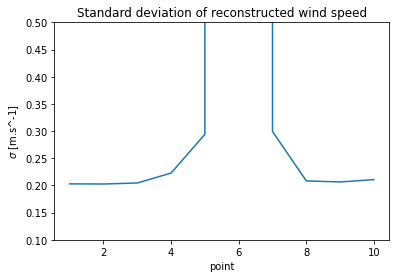

In [65]:
mc_dual_Doppler.data.rc_wind.ws.std(axis = 0).plot()


plt.title('Standard deviation of reconstructed wind speed')
plt.ylim(0.1,0.5)
plt.ylabel('$\sigma$ [m.s^-1]')